<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Modify this cell to add your group name, group number and your names and student IDs

Group: 99

Authors: Yang Yang 1552139, Ying Lu 1557548

In [1]:
import requests
import io
import pandas as pd
import xarray as xa

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load training/testing dataset

In [2]:
def load_dataset_from_url(url):
    """
    Loads a dataset from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    x: Input features in numpy array format
    y: Targets/labels in numpy array format
    """
    
    response = requests.get(url)
    response.raise_for_status()
    
    dataset = np.load(io.BytesIO(response.content)) 
    
    x, y = np.split(dataset, [9], axis=2)
    
    return x, y
    
    
# Downloading may take a while..
train_x, train_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/gVrTFgSJ1rWl1IN/download')
test_x, test_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/JR0WXbrzzTAmwEB/download')

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (10000, 1000, 9)
train_y shape: (10000, 1000, 1)

test_x shape: (2000, 1000, 9)
test_y shape: (2000, 1000, 1)


### Visualize some of the training samples

In [3]:
#TODO Implement the solution to task 2 of assignment 1

train_y, test_y = train_y.squeeze(-1), test_y.squeeze(-1)

In [4]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

In [5]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1),
            #nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.rnn = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x).permute(0, 2, 1)
        x, (_, _) = self.rnn(x)
        x = self.fc(x)
        return x.permute(0, 2, 1)

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_dataLoader: torch.utils.data.Dataset,
                 validation_dataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_dataLoader = training_dataLoader
        self.validation_dataLoader = validation_dataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):
        train_losses_total = []
        val_losses_total = []
        train_acc_total = []
        val_acc_total = []

        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            train_losses=[]
            correct = 0
            sample_num = 0
            for batch in self.training_dataLoader:
                x, y = batch
                input, target = x.to(device=self.device, dtype=torch.float), y.to(self.device) # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate training loss

                # train accuracy
                predict = torch.argmax(out, dim=1)
                correct = correct + torch.sum(predict == target).item()
                sample_num = sample_num + torch.numel(target)
                
                # train loss
                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            self.model.eval()  # evaluation mode
            val_losses = []  # accumulate the losses here

            correct_val = 0
            sample_num_val = 0
            for batch in self.validation_dataLoader:
                x, y = batch
                input, target = x.to(device=self.device, dtype=torch.float), y.to(device=self.device)  # send to device (GPU or CPU)
                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate validation loss
                  
                    #validation accuracy
                    predict = torch.argmax(out, dim=1)
                    correct_val = correct_val + torch.sum(predict == target).item()
                    sample_num_val = sample_num_val + torch.numel(target)
                    
                    #validataion loss
                    loss_value = loss.item()
                    val_losses.append(loss_value)
                    
            print('Epoch:', epoch)
            #print('Training loss,', np.mean(train_losses))
            #print('Training acc,', correct * 1.0 / sample_num)
            #print('Validation loss,', np.mean(val_losses))
            #print('Validation acc,', correct_val * 1.0 / sample_num_val)
            print("Loss_train: {}, Loss_val: {} \t ACC_train: {}, ACC_val: {}".format(np.mean(train_losses), np.mean(val_losses), correct * 1.0 / sample_num, correct_val * 1.0 / sample_num_val))

            train_losses_total.append(np.mean(train_losses))
            train_acc_total.append(correct * 1.0 / sample_num)
            val_losses_total.append(np.mean(val_losses))
            val_acc_total.append(correct_val * 1.0 / sample_num_val)

          

        fig, axs = plt.subplots(2, 1)
        t = range(1, self.epochs + 1)
        axs[0].plot(t, train_losses_total, label = 'Training Loss')
        axs[0].plot(t, val_losses_total, label = 'Validation Loss')
        axs[0].set_xlabel('epoch')
        axs[0].set_ylabel('loss')
        axs[0].grid(True)
        axs[0].legend()

        axs[1].plot(t, train_acc_total, label = 'Training Accuracy')
        axs[1].plot(t, val_acc_total, label = 'Validation Accuracy')
        axs[1].set_xlabel('epoch')
        axs[1].set_ylabel('accuracy')
        axs[1].grid(True)
        axs[1].legend()
       
        fig.tight_layout()
        plt.show()



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = xm.xla_device() if os.environ['COLAB_TPU_ADDR'] else torch.device('cpu')
BATCH_SIZE = 32
NUM_CLASSES = 6
NUM_FEATURES = 9
HIDDEN_SIZE = 128
NUM_RNN_LAYERS = 1
NUM_EPOCH = 150

In [8]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)
train_data = TensorDataset(torch.tensor(train_x), torch.tensor(train_y, dtype=torch.long))
val_data = TensorDataset(torch.tensor(val_x), torch.tensor(val_y, dtype=torch.long))
test_data = TensorDataset(torch.tensor(test_x), torch.tensor(test_y, dtype=torch.long))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)


In [9]:

model = RNNClassifier(input_size=NUM_FEATURES, hidden_size=HIDDEN_SIZE, num_classes=NUM_CLASSES, num_layers=NUM_RNN_LAYERS).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

trainer = Trainer(model=model, device=device, criterion=criterion, optimizer=optimizer, training_dataLoader=train_dataloader, validation_dataLoader=val_dataloader, epochs=NUM_EPOCH)

  1%|          | 1/150 [00:12<31:13, 12.57s/it]

Epoch: 0
Loss_train: 1.78610857629776, Loss_val: 1.7764925332296462 	 ACC_train: 0.1887825, ACC_val: 0.203027


  1%|▏         | 2/150 [00:25<30:57, 12.55s/it]

Epoch: 1
Loss_train: 1.7731009697914124, Loss_val: 1.7692268765161907 	 ACC_train: 0.21387175, ACC_val: 0.2043505


  2%|▏         | 3/150 [00:37<30:44, 12.55s/it]

Epoch: 2
Loss_train: 1.7683622751235961, Loss_val: 1.7657769104791066 	 ACC_train: 0.278000875, ACC_val: 0.3890235


  3%|▎         | 4/150 [00:50<30:27, 12.52s/it]

Epoch: 3
Loss_train: 1.7652565493583678, Loss_val: 1.762540168232388 	 ACC_train: 0.35162075, ACC_val: 0.390875


  3%|▎         | 5/150 [01:02<30:15, 12.52s/it]

Epoch: 4
Loss_train: 1.7613846006393432, Loss_val: 1.757743580000741 	 ACC_train: 0.378762, ACC_val: 0.391122


  4%|▍         | 6/150 [01:15<30:04, 12.53s/it]

Epoch: 5
Loss_train: 1.7547640867233276, Loss_val: 1.7487710544041224 	 ACC_train: 0.378575625, ACC_val: 0.3845445


  5%|▍         | 7/150 [01:27<29:50, 12.52s/it]

Epoch: 6
Loss_train: 1.7414263443946838, Loss_val: 1.7295945504355053 	 ACC_train: 0.38021775, ACC_val: 0.383694


  5%|▌         | 8/150 [01:40<29:39, 12.53s/it]

Epoch: 7
Loss_train: 1.7089806685447693, Loss_val: 1.6776389583708748 	 ACC_train: 0.389044625, ACC_val: 0.395823


  6%|▌         | 9/150 [01:52<29:30, 12.55s/it]

Epoch: 8
Loss_train: 1.612348590373993, Loss_val: 1.521896693441603 	 ACC_train: 0.39858775, ACC_val: 0.3960895


  7%|▋         | 10/150 [02:05<29:19, 12.57s/it]

Epoch: 9
Loss_train: 1.4257014389038085, Loss_val: 1.3561880418232508 	 ACC_train: 0.40385725, ACC_val: 0.4025835


  7%|▋         | 11/150 [02:18<29:08, 12.58s/it]

Epoch: 10
Loss_train: 1.3239208688735962, Loss_val: 1.3053210652063763 	 ACC_train: 0.42618425, ACC_val: 0.422613


  8%|▊         | 12/150 [02:30<29:02, 12.62s/it]

Epoch: 11
Loss_train: 1.283938084602356, Loss_val: 1.2681442007185921 	 ACC_train: 0.455229125, ACC_val: 0.4619935


  9%|▊         | 13/150 [02:43<28:53, 12.65s/it]

Epoch: 12
Loss_train: 1.2472116532325745, Loss_val: 1.2224953458422707 	 ACC_train: 0.48115175, ACC_val: 0.4879885


  9%|▉         | 14/150 [02:56<28:43, 12.67s/it]

Epoch: 13
Loss_train: 1.198396774291992, Loss_val: 1.153093657796345 	 ACC_train: 0.498201375, ACC_val: 0.51315


 10%|█         | 15/150 [03:08<28:27, 12.65s/it]

Epoch: 14
Loss_train: 1.124389249563217, Loss_val: 1.087112527991098 	 ACC_train: 0.513483125, ACC_val: 0.523686


 11%|█         | 16/150 [03:21<28:04, 12.57s/it]

Epoch: 15
Loss_train: 1.063957493543625, Loss_val: 1.0321972483680362 	 ACC_train: 0.527388125, ACC_val: 0.5420415


 11%|█▏        | 17/150 [03:33<27:46, 12.53s/it]

Epoch: 16
Loss_train: 1.024826873779297, Loss_val: 0.9993372105416798 	 ACC_train: 0.54484475, ACC_val: 0.5748475


 12%|█▏        | 18/150 [03:46<27:29, 12.49s/it]

Epoch: 17
Loss_train: 1.001960782289505, Loss_val: 0.9869023173574417 	 ACC_train: 0.562879625, ACC_val: 0.558182


 13%|█▎        | 19/150 [03:58<27:14, 12.48s/it]

Epoch: 18
Loss_train: 0.9844516153335572, Loss_val: 0.9729633539442032 	 ACC_train: 0.57072525, ACC_val: 0.572162


 13%|█▎        | 20/150 [04:10<26:59, 12.46s/it]

Epoch: 19
Loss_train: 0.9705777273178101, Loss_val: 0.9587082077586462 	 ACC_train: 0.580707375, ACC_val: 0.5797685


 14%|█▍        | 21/150 [04:23<26:46, 12.45s/it]

Epoch: 20
Loss_train: 0.9590944583415986, Loss_val: 0.938443712771885 	 ACC_train: 0.588749625, ACC_val: 0.5916395


 15%|█▍        | 22/150 [04:35<26:32, 12.44s/it]

Epoch: 21
Loss_train: 0.9476937732696533, Loss_val: 0.9300303288868496 	 ACC_train: 0.59354875, ACC_val: 0.598066


 15%|█▌        | 23/150 [04:48<26:18, 12.43s/it]

Epoch: 22
Loss_train: 0.9384438328742981, Loss_val: 0.9188409485514202 	 ACC_train: 0.5969215, ACC_val: 0.601421


 16%|█▌        | 24/150 [05:00<26:05, 12.42s/it]

Epoch: 23
Loss_train: 0.9310911436080933, Loss_val: 0.9136176648594084 	 ACC_train: 0.598858625, ACC_val: 0.605301


 17%|█▋        | 25/150 [05:12<25:52, 12.42s/it]

Epoch: 24
Loss_train: 0.9254441704750062, Loss_val: 0.9142986923929245 	 ACC_train: 0.60032525, ACC_val: 0.608078


 17%|█▋        | 26/150 [05:25<25:39, 12.42s/it]

Epoch: 25
Loss_train: 0.9188318963050842, Loss_val: 0.9044131750152224 	 ACC_train: 0.601805125, ACC_val: 0.611648


 18%|█▊        | 27/150 [05:37<25:29, 12.43s/it]

Epoch: 26
Loss_train: 0.9119571523666382, Loss_val: 0.8977413045035468 	 ACC_train: 0.60387075, ACC_val: 0.6144815


 19%|█▊        | 28/150 [05:50<25:16, 12.43s/it]

Epoch: 27
Loss_train: 0.9045805740356445, Loss_val: 0.8856127640557667 	 ACC_train: 0.606200625, ACC_val: 0.616105


 19%|█▉        | 29/150 [06:02<25:03, 12.43s/it]

Epoch: 28
Loss_train: 0.8994617481231689, Loss_val: 0.8731148706542121 	 ACC_train: 0.607480875, ACC_val: 0.6157745


 20%|██        | 30/150 [06:15<24:50, 12.42s/it]

Epoch: 29
Loss_train: 0.8950217168331146, Loss_val: 0.8606876011878725 	 ACC_train: 0.608176875, ACC_val: 0.6148045


 21%|██        | 31/150 [06:27<24:37, 12.41s/it]

Epoch: 30
Loss_train: 0.8878150119781494, Loss_val: 0.8595835708436512 	 ACC_train: 0.610427, ACC_val: 0.6169045


 21%|██▏       | 32/150 [06:39<24:24, 12.41s/it]

Epoch: 31
Loss_train: 0.8845955808162689, Loss_val: 0.8517464039817689 	 ACC_train: 0.61119, ACC_val: 0.61843


 22%|██▏       | 33/150 [06:52<24:12, 12.42s/it]

Epoch: 32
Loss_train: 0.8788035371303559, Loss_val: 0.8441815527658614 	 ACC_train: 0.61332675, ACC_val: 0.6200915


 23%|██▎       | 34/150 [07:04<24:00, 12.42s/it]

Epoch: 33
Loss_train: 0.8721506233215333, Loss_val: 0.840881471596067 	 ACC_train: 0.61561775, ACC_val: 0.622422


 23%|██▎       | 35/150 [07:17<23:48, 12.42s/it]

Epoch: 34
Loss_train: 0.8649257605075836, Loss_val: 0.8320045868555704 	 ACC_train: 0.617921125, ACC_val: 0.6252285


 24%|██▍       | 36/150 [07:29<23:35, 12.42s/it]

Epoch: 35
Loss_train: 0.8584962589740753, Loss_val: 0.8261626031663682 	 ACC_train: 0.62026375, ACC_val: 0.628577


 25%|██▍       | 37/150 [07:41<23:23, 12.42s/it]

Epoch: 36
Loss_train: 0.8502316768169403, Loss_val: 0.8150373801352486 	 ACC_train: 0.623396125, ACC_val: 0.6322145


 25%|██▌       | 38/150 [07:54<23:10, 12.42s/it]

Epoch: 37
Loss_train: 0.8432699520587921, Loss_val: 0.8069900056672474 	 ACC_train: 0.6271825, ACC_val: 0.6380225


 26%|██▌       | 39/150 [08:06<22:56, 12.40s/it]

Epoch: 38
Loss_train: 0.8339520454406738, Loss_val: 0.794606261783176 	 ACC_train: 0.63352425, ACC_val: 0.649417


 27%|██▋       | 40/150 [08:19<22:46, 12.42s/it]

Epoch: 39
Loss_train: 0.8219629070758819, Loss_val: 0.7924469662091088 	 ACC_train: 0.641711375, ACC_val: 0.667328


 27%|██▋       | 41/150 [08:31<22:35, 12.44s/it]

Epoch: 40
Loss_train: 0.8063850755691528, Loss_val: 0.7871807879871793 	 ACC_train: 0.651589875, ACC_val: 0.6804215


 28%|██▊       | 42/150 [08:44<22:23, 12.44s/it]

Epoch: 41
Loss_train: 0.7882959640026093, Loss_val: 0.7416389206099132 	 ACC_train: 0.663549125, ACC_val: 0.693413


 29%|██▊       | 43/150 [08:56<22:11, 12.45s/it]

Epoch: 42
Loss_train: 0.7577866415977478, Loss_val: 0.6981552735207572 	 ACC_train: 0.6821775, ACC_val: 0.710488


 29%|██▉       | 44/150 [09:09<22:00, 12.45s/it]

Epoch: 43
Loss_train: 0.7007793126106262, Loss_val: 0.623606644925617 	 ACC_train: 0.715224625, ACC_val: 0.750843


 30%|███       | 45/150 [09:21<21:47, 12.45s/it]

Epoch: 44
Loss_train: 0.6242141752243042, Loss_val: 0.5485620692608848 	 ACC_train: 0.75102725, ACC_val: 0.7907185


 31%|███       | 46/150 [09:33<21:34, 12.45s/it]

Epoch: 45
Loss_train: 0.5679157983064651, Loss_val: 0.5133661954175859 	 ACC_train: 0.777484375, ACC_val: 0.798415


 31%|███▏      | 47/150 [09:46<21:23, 12.46s/it]

Epoch: 46
Loss_train: 0.524562375664711, Loss_val: 0.48864321339698064 	 ACC_train: 0.795371875, ACC_val: 0.8010495


 32%|███▏      | 48/150 [09:58<21:10, 12.46s/it]

Epoch: 47
Loss_train: 0.5003240871429443, Loss_val: 0.4620043025130317 	 ACC_train: 0.808036125, ACC_val: 0.8243385


 33%|███▎      | 49/150 [10:11<20:58, 12.46s/it]

Epoch: 48
Loss_train: 0.47945935297012326, Loss_val: 0.44593902381639633 	 ACC_train: 0.823476375, ACC_val: 0.8363465


 33%|███▎      | 50/150 [10:23<20:46, 12.46s/it]

Epoch: 49
Loss_train: 0.45783362913131714, Loss_val: 0.4180623898430476 	 ACC_train: 0.834502, ACC_val: 0.8463415


 34%|███▍      | 51/150 [10:36<20:34, 12.47s/it]

Epoch: 50
Loss_train: 0.4382360956668854, Loss_val: 0.39127018290852744 	 ACC_train: 0.84133175, ACC_val: 0.8583685


 35%|███▍      | 52/150 [10:48<20:21, 12.47s/it]

Epoch: 51
Loss_train: 0.4435785075426102, Loss_val: 0.388133521590914 	 ACC_train: 0.837917375, ACC_val: 0.8595635


 35%|███▌      | 53/150 [11:01<20:08, 12.46s/it]

Epoch: 52
Loss_train: 0.4178060508966446, Loss_val: 0.4138426198845818 	 ACC_train: 0.84813125, ACC_val: 0.8403135


 36%|███▌      | 54/150 [11:13<19:56, 12.46s/it]

Epoch: 53
Loss_train: 0.39953959167003633, Loss_val: 0.3607228209101965 	 ACC_train: 0.855971875, ACC_val: 0.867587


 37%|███▋      | 55/150 [11:26<19:43, 12.46s/it]

Epoch: 54
Loss_train: 0.3893222907781601, Loss_val: 0.36187701849710374 	 ACC_train: 0.859515, ACC_val: 0.869753


 37%|███▋      | 56/150 [11:38<19:31, 12.47s/it]

Epoch: 55
Loss_train: 0.3718231999874115, Loss_val: 0.33836536866331857 	 ACC_train: 0.866810625, ACC_val: 0.87864


 38%|███▊      | 57/150 [11:51<19:18, 12.46s/it]

Epoch: 56
Loss_train: 0.369836505651474, Loss_val: 0.33994392459354705 	 ACC_train: 0.866941625, ACC_val: 0.8774865


 39%|███▊      | 58/150 [12:03<19:05, 12.45s/it]

Epoch: 57
Loss_train: 0.3717268559932709, Loss_val: 0.33054524045141914 	 ACC_train: 0.86569625, ACC_val: 0.8823265


 39%|███▉      | 59/150 [12:15<18:53, 12.46s/it]

Epoch: 58
Loss_train: 0.3512441672086716, Loss_val: 0.3174887474567171 	 ACC_train: 0.87442675, ACC_val: 0.887231


 40%|████      | 60/150 [12:28<18:40, 12.45s/it]

Epoch: 59
Loss_train: 0.3477268753647804, Loss_val: 0.3101920894687138 	 ACC_train: 0.875996375, ACC_val: 0.8914145


 41%|████      | 61/150 [12:40<18:28, 12.45s/it]

Epoch: 60
Loss_train: 0.3401362328529358, Loss_val: 0.30553245662696776 	 ACC_train: 0.87919925, ACC_val: 0.8919435


 41%|████▏     | 62/150 [12:53<18:16, 12.46s/it]

Epoch: 61
Loss_train: 0.32993071448802946, Loss_val: 0.29525843097103965 	 ACC_train: 0.884599625, ACC_val: 0.899746


 42%|████▏     | 63/150 [13:05<18:03, 12.46s/it]

Epoch: 62
Loss_train: 0.31950300139188764, Loss_val: 0.28451655994332026 	 ACC_train: 0.88949525, ACC_val: 0.904298


 43%|████▎     | 64/150 [13:18<17:51, 12.46s/it]

Epoch: 63
Loss_train: 0.31807225620746615, Loss_val: 0.29333056935242247 	 ACC_train: 0.88915675, ACC_val: 0.8980785


 43%|████▎     | 65/150 [13:30<17:39, 12.47s/it]

Epoch: 64
Loss_train: 0.313703069627285, Loss_val: 0.2878581271285102 	 ACC_train: 0.891069375, ACC_val: 0.902266


 44%|████▍     | 66/150 [13:43<17:27, 12.47s/it]

Epoch: 65
Loss_train: 0.3052466275691986, Loss_val: 0.29022445257694 	 ACC_train: 0.894720125, ACC_val: 0.900418


 45%|████▍     | 67/150 [13:55<17:15, 12.47s/it]

Epoch: 66
Loss_train: 0.30097313272953036, Loss_val: 0.27687013645966846 	 ACC_train: 0.896817125, ACC_val: 0.9071045


 45%|████▌     | 68/150 [14:08<17:03, 12.48s/it]

Epoch: 67
Loss_train: 0.2933099851608276, Loss_val: 0.2659719340384953 	 ACC_train: 0.900193125, ACC_val: 0.9089445


 46%|████▌     | 69/150 [14:20<16:50, 12.48s/it]

Epoch: 68
Loss_train: 0.2987588686347008, Loss_val: 0.2600844980232299 	 ACC_train: 0.897275, ACC_val: 0.9123015


 47%|████▋     | 70/150 [14:33<16:38, 12.48s/it]

Epoch: 69
Loss_train: 0.2823122109770775, Loss_val: 0.2591589606470532 	 ACC_train: 0.904757875, ACC_val: 0.9162645


 47%|████▋     | 71/150 [14:45<16:25, 12.47s/it]

Epoch: 70
Loss_train: 0.2816103621125221, Loss_val: 0.246876846703272 	 ACC_train: 0.904405375, ACC_val: 0.920314


 48%|████▊     | 72/150 [14:58<16:13, 12.48s/it]

Epoch: 71
Loss_train: 0.2772123745083809, Loss_val: 0.24571183252902257 	 ACC_train: 0.906175875, ACC_val: 0.917112


 49%|████▊     | 73/150 [15:10<16:01, 12.48s/it]

Epoch: 72
Loss_train: 0.2710649996995926, Loss_val: 0.24571401046382058 	 ACC_train: 0.9087785, ACC_val: 0.917756


 49%|████▉     | 74/150 [15:23<15:48, 12.47s/it]

Epoch: 73
Loss_train: 0.2699866017103195, Loss_val: 0.23917910716836416 	 ACC_train: 0.90916975, ACC_val: 0.9220205


 50%|█████     | 75/150 [15:35<15:35, 12.47s/it]

Epoch: 74
Loss_train: 0.26518757915496827, Loss_val: 0.24162618910509442 	 ACC_train: 0.910876625, ACC_val: 0.919303


 51%|█████     | 76/150 [15:47<15:22, 12.47s/it]

Epoch: 75
Loss_train: 0.2600172414183617, Loss_val: 0.23121223515934414 	 ACC_train: 0.913129125, ACC_val: 0.9232165


 51%|█████▏    | 77/150 [16:00<15:09, 12.47s/it]

Epoch: 76
Loss_train: 0.2592740505337715, Loss_val: 0.2559240183659962 	 ACC_train: 0.913632875, ACC_val: 0.920661


 52%|█████▏    | 78/150 [16:12<14:57, 12.47s/it]

Epoch: 77
Loss_train: 0.2596854630112648, Loss_val: 0.2248338304814838 	 ACC_train: 0.913846125, ACC_val: 0.9268885


 53%|█████▎    | 79/150 [16:25<14:45, 12.47s/it]

Epoch: 78
Loss_train: 0.2532030090689659, Loss_val: 0.2204213421496134 	 ACC_train: 0.915414125, ACC_val: 0.9272555


 53%|█████▎    | 80/150 [16:37<14:33, 12.47s/it]

Epoch: 79
Loss_train: 0.25794913893938065, Loss_val: 0.22467382157605792 	 ACC_train: 0.9138905, ACC_val: 0.9274525


 54%|█████▍    | 81/150 [16:50<14:20, 12.47s/it]

Epoch: 80
Loss_train: 0.2468020577430725, Loss_val: 0.21182725708636027 	 ACC_train: 0.91809225, ACC_val: 0.9320395


 55%|█████▍    | 82/150 [17:02<14:07, 12.46s/it]

Epoch: 81
Loss_train: 0.23916722965240478, Loss_val: 0.2101974082844598 	 ACC_train: 0.92098, ACC_val: 0.931755


 55%|█████▌    | 83/150 [17:15<13:54, 12.46s/it]

Epoch: 82
Loss_train: 0.2402191585302353, Loss_val: 0.2171951804369215 	 ACC_train: 0.920203375, ACC_val: 0.92891


 56%|█████▌    | 84/150 [17:27<13:42, 12.46s/it]

Epoch: 83
Loss_train: 0.23746732461452486, Loss_val: 0.21397222767746638 	 ACC_train: 0.921133, ACC_val: 0.9303105


 57%|█████▋    | 85/150 [17:40<13:29, 12.46s/it]

Epoch: 84
Loss_train: 0.23526343524456025, Loss_val: 0.21039916574954987 	 ACC_train: 0.921431125, ACC_val: 0.9304415


 57%|█████▋    | 86/150 [17:52<13:17, 12.46s/it]

Epoch: 85
Loss_train: 0.23084253436326982, Loss_val: 0.2039986238593147 	 ACC_train: 0.923692875, ACC_val: 0.932229


 58%|█████▊    | 87/150 [18:05<13:04, 12.46s/it]

Epoch: 86
Loss_train: 0.22777164995670318, Loss_val: 0.2096361449313542 	 ACC_train: 0.924574375, ACC_val: 0.931066


 59%|█████▊    | 88/150 [18:17<12:53, 12.47s/it]

Epoch: 87
Loss_train: 0.22257231330871582, Loss_val: 0.19483021161859 	 ACC_train: 0.92635075, ACC_val: 0.9359815


 59%|█████▉    | 89/150 [18:30<12:40, 12.47s/it]

Epoch: 88
Loss_train: 0.2234159778356552, Loss_val: 0.1922192010614607 	 ACC_train: 0.925729875, ACC_val: 0.936529


 60%|██████    | 90/150 [18:42<12:27, 12.46s/it]

Epoch: 89
Loss_train: 0.21903624701499938, Loss_val: 0.19774127077488673 	 ACC_train: 0.92786825, ACC_val: 0.935234


 61%|██████    | 91/150 [18:54<12:15, 12.46s/it]

Epoch: 90
Loss_train: 0.22359082794189453, Loss_val: 0.19597433791274116 	 ACC_train: 0.925772625, ACC_val: 0.9339795


 61%|██████▏   | 92/150 [19:07<12:02, 12.46s/it]

Epoch: 91
Loss_train: 0.21290833669900894, Loss_val: 0.1907060117948623 	 ACC_train: 0.929845375, ACC_val: 0.9365385


 62%|██████▏   | 93/150 [19:19<11:50, 12.46s/it]

Epoch: 92
Loss_train: 0.2261311247944832, Loss_val: 0.1945253149384544 	 ACC_train: 0.924561875, ACC_val: 0.934814


 63%|██████▎   | 94/150 [19:32<11:37, 12.46s/it]

Epoch: 93
Loss_train: 0.2150427206158638, Loss_val: 0.18706768798449683 	 ACC_train: 0.928425375, ACC_val: 0.93734


 63%|██████▎   | 95/150 [19:44<11:25, 12.46s/it]

Epoch: 94
Loss_train: 0.20897778183221816, Loss_val: 0.18428597492831095 	 ACC_train: 0.931151, ACC_val: 0.938427


 64%|██████▍   | 96/150 [19:57<11:12, 12.45s/it]

Epoch: 95
Loss_train: 0.237994608938694, Loss_val: 0.1948927148940071 	 ACC_train: 0.920056, ACC_val: 0.934245


 65%|██████▍   | 97/150 [20:09<11:00, 12.46s/it]

Epoch: 96
Loss_train: 0.2152626947760582, Loss_val: 0.19376211672548263 	 ACC_train: 0.92733775, ACC_val: 0.9353455


 65%|██████▌   | 98/150 [20:22<10:47, 12.46s/it]

Epoch: 97
Loss_train: 0.21368001419305802, Loss_val: 0.19326244436559223 	 ACC_train: 0.928103625, ACC_val: 0.931635


 66%|██████▌   | 99/150 [20:34<10:35, 12.46s/it]

Epoch: 98
Loss_train: 0.2018331561088562, Loss_val: 0.1766330964035458 	 ACC_train: 0.933242125, ACC_val: 0.94085


 67%|██████▋   | 100/150 [20:47<10:22, 12.45s/it]

Epoch: 99
Loss_train: 0.20136782529950142, Loss_val: 0.20193735285410805 	 ACC_train: 0.933568375, ACC_val: 0.928521


 67%|██████▋   | 101/150 [20:59<10:10, 12.45s/it]

Epoch: 100
Loss_train: 0.1972711814045906, Loss_val: 0.17062517220065707 	 ACC_train: 0.935038, ACC_val: 0.942336


 68%|██████▊   | 102/150 [21:11<09:58, 12.46s/it]

Epoch: 101
Loss_train: 0.19580938905477524, Loss_val: 0.17320980675636777 	 ACC_train: 0.93514575, ACC_val: 0.9424285


 69%|██████▊   | 103/150 [21:24<09:45, 12.45s/it]

Epoch: 102
Loss_train: 0.19519020992517472, Loss_val: 0.17363378169044616 	 ACC_train: 0.935835, ACC_val: 0.9423075


 69%|██████▉   | 104/150 [21:36<09:33, 12.46s/it]

Epoch: 103
Loss_train: 0.19301615905761718, Loss_val: 0.17508830946116222 	 ACC_train: 0.936305625, ACC_val: 0.940961


 70%|███████   | 105/150 [21:49<09:20, 12.45s/it]

Epoch: 104
Loss_train: 0.1932776750922203, Loss_val: 0.1698068090611034 	 ACC_train: 0.9364085, ACC_val: 0.94304


 71%|███████   | 106/150 [22:01<09:07, 12.45s/it]

Epoch: 105
Loss_train: 0.18942406940460205, Loss_val: 0.16568519896458064 	 ACC_train: 0.9376125, ACC_val: 0.9447995


 71%|███████▏  | 107/150 [22:14<08:55, 12.45s/it]

Epoch: 106
Loss_train: 0.18663466712832452, Loss_val: 0.16548844947228356 	 ACC_train: 0.93897825, ACC_val: 0.944318


 72%|███████▏  | 108/150 [22:26<08:43, 12.46s/it]

Epoch: 107
Loss_train: 0.19487693566083908, Loss_val: 0.1671412287959977 	 ACC_train: 0.9358875, ACC_val: 0.9446925


 73%|███████▎  | 109/150 [22:39<08:30, 12.46s/it]

Epoch: 108
Loss_train: 0.18323915112018585, Loss_val: 0.16615325224304955 	 ACC_train: 0.940283625, ACC_val: 0.943753


 73%|███████▎  | 110/150 [22:51<08:18, 12.46s/it]

Epoch: 109
Loss_train: 0.18669020667672157, Loss_val: 0.1615487022532357 	 ACC_train: 0.93860875, ACC_val: 0.9457


 74%|███████▍  | 111/150 [23:04<08:06, 12.47s/it]

Epoch: 110
Loss_train: 0.18324456575512887, Loss_val: 0.16094535553739184 	 ACC_train: 0.939883375, ACC_val: 0.946424


 75%|███████▍  | 112/150 [23:16<07:53, 12.47s/it]

Epoch: 111
Loss_train: 0.1848203582763672, Loss_val: 0.160946053999757 	 ACC_train: 0.9388025, ACC_val: 0.945497


 75%|███████▌  | 113/150 [23:29<07:41, 12.47s/it]

Epoch: 112
Loss_train: 0.18373209458589554, Loss_val: 0.15879010976780028 	 ACC_train: 0.939800125, ACC_val: 0.9463275


 76%|███████▌  | 114/150 [23:41<07:28, 12.46s/it]

Epoch: 113
Loss_train: 0.1780099865794182, Loss_val: 0.16074469744686096 	 ACC_train: 0.941981875, ACC_val: 0.9472575


 77%|███████▋  | 115/150 [23:53<07:16, 12.46s/it]

Epoch: 114
Loss_train: 0.17881715387105943, Loss_val: 0.15734541865568313 	 ACC_train: 0.941540625, ACC_val: 0.94708


 77%|███████▋  | 116/150 [24:06<07:03, 12.47s/it]

Epoch: 115
Loss_train: 0.17819616290926935, Loss_val: 0.1556175992129341 	 ACC_train: 0.941634875, ACC_val: 0.947093


 78%|███████▊  | 117/150 [24:18<06:51, 12.47s/it]

Epoch: 116
Loss_train: 0.17479561001062394, Loss_val: 0.15340341367418803 	 ACC_train: 0.9427875, ACC_val: 0.951376


 79%|███████▊  | 118/150 [24:31<06:39, 12.47s/it]

Epoch: 117
Loss_train: 0.1772761352956295, Loss_val: 0.1593692677598151 	 ACC_train: 0.941976375, ACC_val: 0.9467875


 79%|███████▉  | 119/150 [24:43<06:26, 12.47s/it]

Epoch: 118
Loss_train: 0.1775854595005512, Loss_val: 0.15247794335323667 	 ACC_train: 0.941646125, ACC_val: 0.9482395


 80%|████████  | 120/150 [24:56<06:14, 12.48s/it]

Epoch: 119
Loss_train: 0.17352967056632043, Loss_val: 0.15089898024286544 	 ACC_train: 0.943273375, ACC_val: 0.9541165


 81%|████████  | 121/150 [25:08<06:01, 12.48s/it]

Epoch: 120
Loss_train: 0.17351691129803656, Loss_val: 0.15055866527651984 	 ACC_train: 0.9432275, ACC_val: 0.948687


 81%|████████▏ | 122/150 [25:21<05:49, 12.48s/it]

Epoch: 121
Loss_train: 0.18650869035720824, Loss_val: 0.16405066776843297 	 ACC_train: 0.937401375, ACC_val: 0.943627


 82%|████████▏ | 123/150 [25:33<05:36, 12.47s/it]

Epoch: 122
Loss_train: 0.18268040004372596, Loss_val: 0.16282206241573607 	 ACC_train: 0.93834175, ACC_val: 0.944373


 83%|████████▎ | 124/150 [25:46<05:23, 12.46s/it]

Epoch: 123
Loss_train: 0.1770088175237179, Loss_val: 0.1494840325580703 	 ACC_train: 0.941218625, ACC_val: 0.948456


 83%|████████▎ | 125/150 [25:58<05:11, 12.45s/it]

Epoch: 124
Loss_train: 0.17452017709612846, Loss_val: 0.14624070163284028 	 ACC_train: 0.942497125, ACC_val: 0.949614


 84%|████████▍ | 126/150 [26:11<04:58, 12.44s/it]

Epoch: 125
Loss_train: 0.1663518065214157, Loss_val: 0.14800441324237792 	 ACC_train: 0.94533975, ACC_val: 0.948593


 85%|████████▍ | 127/150 [26:23<04:46, 12.45s/it]

Epoch: 126
Loss_train: 0.16448664864897727, Loss_val: 0.15314722380467824 	 ACC_train: 0.946183, ACC_val: 0.94738


 85%|████████▌ | 128/150 [26:36<04:34, 12.46s/it]

Epoch: 127
Loss_train: 0.16706107032299042, Loss_val: 0.14922999164887837 	 ACC_train: 0.9453975, ACC_val: 0.9488065


 86%|████████▌ | 129/150 [26:48<04:21, 12.47s/it]

Epoch: 128
Loss_train: 0.1619073523581028, Loss_val: 0.1456693634390831 	 ACC_train: 0.94720675, ACC_val: 0.951223


 87%|████████▋ | 130/150 [27:00<04:09, 12.46s/it]

Epoch: 129
Loss_train: 0.1629881103336811, Loss_val: 0.1447648187241857 	 ACC_train: 0.946483875, ACC_val: 0.952036


 87%|████████▋ | 131/150 [27:13<03:56, 12.47s/it]

Epoch: 130
Loss_train: 0.16693502420186995, Loss_val: 0.20807835128572252 	 ACC_train: 0.944566875, ACC_val: 0.928356


 88%|████████▊ | 132/150 [27:25<03:44, 12.47s/it]

Epoch: 131
Loss_train: 0.18752333319187164, Loss_val: 0.15332985350063869 	 ACC_train: 0.936077125, ACC_val: 0.9470055


 89%|████████▊ | 133/150 [27:38<03:31, 12.47s/it]

Epoch: 132
Loss_train: 0.1708726015985012, Loss_val: 0.1529025359759255 	 ACC_train: 0.942205875, ACC_val: 0.9468325


 89%|████████▉ | 134/150 [27:50<03:19, 12.47s/it]

Epoch: 133
Loss_train: 0.16671836936473847, Loss_val: 0.14898128760239435 	 ACC_train: 0.94358425, ACC_val: 0.947642


 90%|█████████ | 135/150 [28:03<03:06, 12.47s/it]

Epoch: 134
Loss_train: 0.16589327129721643, Loss_val: 0.14365494345861768 	 ACC_train: 0.94416425, ACC_val: 0.9534285


 91%|█████████ | 136/150 [28:15<02:54, 12.47s/it]

Epoch: 135
Loss_train: 0.16166775715351106, Loss_val: 0.17505804709498846 	 ACC_train: 0.9467395, ACC_val: 0.9387245


 91%|█████████▏| 137/150 [28:28<02:42, 12.47s/it]

Epoch: 136
Loss_train: 0.16151492831110953, Loss_val: 0.16766736408074698 	 ACC_train: 0.946723375, ACC_val: 0.9409795


 92%|█████████▏| 138/150 [28:40<02:29, 12.46s/it]

Epoch: 137
Loss_train: 0.1572991268634796, Loss_val: 0.14222529329477795 	 ACC_train: 0.94866875, ACC_val: 0.9504375


 93%|█████████▎| 139/150 [28:53<02:16, 12.45s/it]

Epoch: 138
Loss_train: 0.16159369969367982, Loss_val: 0.14479377712049182 	 ACC_train: 0.94735425, ACC_val: 0.950945


 93%|█████████▎| 140/150 [29:05<02:04, 12.45s/it]

Epoch: 139
Loss_train: 0.15275626757740973, Loss_val: 0.13593511188787127 	 ACC_train: 0.950048375, ACC_val: 0.9544345


 94%|█████████▍| 141/150 [29:17<01:51, 12.44s/it]

Epoch: 140
Loss_train: 0.16198057025671006, Loss_val: 0.1518846864974688 	 ACC_train: 0.946748625, ACC_val: 0.9507665


 95%|█████████▍| 142/150 [29:30<01:39, 12.44s/it]

Epoch: 141
Loss_train: 0.15169785690307616, Loss_val: 0.14378628619606532 	 ACC_train: 0.950127625, ACC_val: 0.9522855


 95%|█████████▌| 143/150 [29:42<01:27, 12.44s/it]

Epoch: 142
Loss_train: 0.15595667853951453, Loss_val: 0.1363713259971331 	 ACC_train: 0.948869, ACC_val: 0.95833


 96%|█████████▌| 144/150 [29:55<01:14, 12.44s/it]

Epoch: 143
Loss_train: 0.14962863370776178, Loss_val: 0.1431021076582727 	 ACC_train: 0.951310375, ACC_val: 0.9517965


 97%|█████████▋| 145/150 [30:07<01:02, 12.43s/it]

Epoch: 144
Loss_train: 0.14702488365769387, Loss_val: 0.14360193577077654 	 ACC_train: 0.95258725, ACC_val: 0.9497825


 97%|█████████▋| 146/150 [30:20<00:49, 12.43s/it]

Epoch: 145
Loss_train: 0.15267014956474304, Loss_val: 0.16341829158010937 	 ACC_train: 0.95044725, ACC_val: 0.938795


 98%|█████████▊| 147/150 [30:32<00:37, 12.42s/it]

Epoch: 146
Loss_train: 0.15032404589653015, Loss_val: 0.14194938256627038 	 ACC_train: 0.9505365, ACC_val: 0.952267


 99%|█████████▊| 148/150 [30:44<00:24, 12.43s/it]

Epoch: 147
Loss_train: 0.1472408105432987, Loss_val: 0.13954423734593013 	 ACC_train: 0.952437, ACC_val: 0.9523385


 99%|█████████▉| 149/150 [30:57<00:12, 12.43s/it]

Epoch: 148
Loss_train: 0.1452229714691639, Loss_val: 0.12276242886270795 	 ACC_train: 0.953196125, ACC_val: 0.9608775


100%|██████████| 150/150 [31:09<00:00, 12.47s/it]

Epoch: 149
Loss_train: 0.1456331334412098, Loss_val: 0.130585606609072 	 ACC_train: 0.952385125, ACC_val: 0.9575555


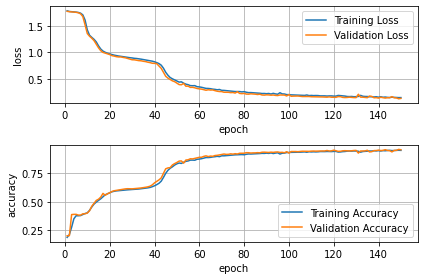

In [10]:
trainer.run_trainer()

In [11]:
def predict(test_dataloader, model, device):
    model.eval()
    outputs = []
    for batch in tqdm(test_dataloader):
        x, y = batch
        input, target = x.to(device=device, dtype=torch.float), y.to(device=device)  # send to device (GPU or CPU)
        with torch.no_grad():
            output = model(input)   # one forward pass
            outputs.append(torch.argmax(output, dim=1).cpu().detach().numpy())
    return np.vstack(outputs)

test_pred = predict(test_dataloader, model, device)

100%|██████████| 63/63 [00:01<00:00, 58.95it/s]


In [12]:
acc = np.sum(test_pred == test_y) / (test_y.shape[0] * test_y.shape[1])
print(acc)

0.959867


In [13]:
# get multiclassification statistics    
    
from sklearn.metrics import precision_recall_fscore_support as score

y_test_array = test_y.reshape(-1)
predicted_array = test_pred.reshape(-1)

precision, recall, fscore, support = score(y_test_array, predicted_array)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.94181685 0.96119077 0.951083   0.97202587 0.92833185 0.99767043]
recall: [0.94613499 0.95627109 0.95494961 0.92966933 0.96607646 0.99915321]
fscore: [0.94397098 0.95872462 0.95301238 0.9503759  0.94682813 0.99841127]
support: [264346 259851 269587 407660 398219 400337]
